https://lightning.ai/docs/pytorch/stable/starter/introduction.html

# 1: Install PyTorch Lightning

In [1]:
# ! pip install lightning

## 2: Define a LightningModule

In [15]:
import os

from torch import optim, nn, utils, Tensor
import torch

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import lightning as L

import pandas as pd

import matplotlib.pyplot as plt

In [3]:
# define any number of nn.Modules (or use your current ones)
encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))
decoder = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

## 3: Define a dataset

In [33]:
# download the dataset
dataset = MNIST(os.getcwd(), download=True, transform=ToTensor())

In [34]:
# create the dataloader
train_loader = utils.data.DataLoader(dataset,
                                     batch_size=32,
                                     shuffle=True)

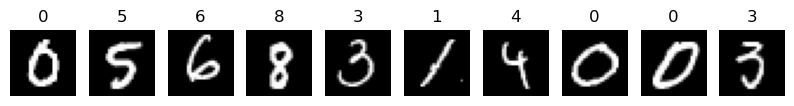

In [35]:
# show one batch
x, y = next(iter(train_loader))

# plot the first ten images and add the labels to the plot
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axs):
    ax.imshow(x[i][0], cmap="gray")
    ax.set_title(y[i].item())
    ax.axis("off")
plt.show()

## 4: Train the model

In [36]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(limit_train_batches=100, max_epochs=100)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
c:\Users\thoma\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## 5: Use the model

In [37]:
# load checkpoint
checkpoint = "./lightning_logs/version_1/checkpoints/epoch=99-step=10000.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)



# choose your trained nn.Module
encoder = autoencoder.encoder
encoder.eval()

# embed 4 fake images!
fake_image_batch = torch.rand(4, 28 * 28, device=autoencoder.device)
embeddings = encoder(fake_image_batch)
print("⚡" * 20, "\nPredictions (4 image embeddings):\n", embeddings, "\n", "⚡" * 20)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ 
Predictions (4 image embeddings):
 tensor([[-1.5384, -0.4311,  0.4073],
        [-1.7323, -0.6781,  0.6776],
        [-1.8683, -0.5035,  0.4337],
        [-1.9351, -0.6130,  0.6641]], grad_fn=<AddmmBackward0>) 
 ⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡


## 6: Import the log-file

In [40]:
# import the file '.\lightning_logs\version_0\metrics.csv' into a pandas DataFrame
df = pd.read_csv("./lightning_logs/version_1/metrics.csv")
df.head()

,epoch,step,train_loss
0,0,49,0.048471
1,0,99,0.049116
2,1,149,0.043971
3,1,199,0.048198
4,2,249,0.046478


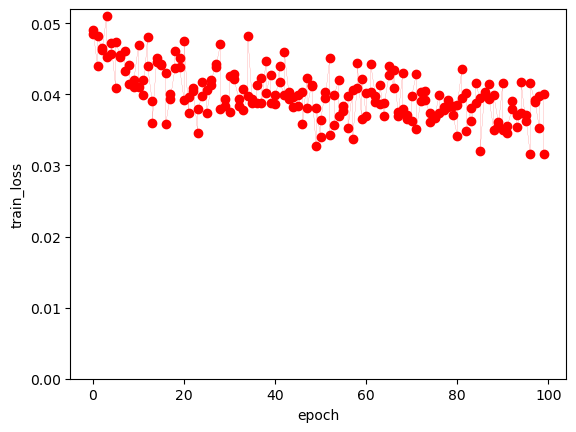

In [41]:
# plot the loss
fig, ax = plt.subplots()
ax.plot(df["epoch"], df["train_loss"],
        marker="o",
        linewidth=0.1,
        color="r")

ax.set_xlabel("epoch")
ax.set_ylabel("train_loss")

# set 0 as the starting point for the y-axis
ax.set_ylim(bottom=0)

plt.show()